In [841]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler

**1.
Tree-Based Methods**

**(a)
Downloading the APS Failure data**

In [844]:
train_file = '../Data/aps_failure_training_set.csv'
test_file = '../Data/aps_failure_test_set.csv'

In [845]:
df_train = pd.read_csv(train_file, skiprows=20, na_values='na').replace({'neg': 0, 'pos': 1, 'na': np.nan})
df_test = pd.read_csv(test_file, skiprows=20, na_values='na').replace({'neg': 0, 'pos': 1, 'na': np.nan})

/var/folders/vy/_bn8m9g92t12zt93ll0c5c600000gn/T/ipykernel_81362/1177599668.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train = pd.read_csv(train_file, skiprows=20, na_values='na').replace({'neg': 0, 'pos': 1, 'na': np.nan})
/var/folders/vy/_bn8m9g92t12zt93ll0c5c600000gn/T/ipykernel_81362/1177599668.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test = pd.read_csv(test_file, skiprows=20, na_values='na').replace({'neg': 0, 'pos': 1, 'na': np.nan})


In [846]:
print(f"Training Data: {df_train.shape}")
print(f"Testing Data: {df_test.shape}")

Training Data: (60000, 171)
Testing Data: (16000, 171)


In [847]:
df_train_X = df_train.iloc[:, 1:]
df_train_Y = df_train.iloc[:, 0]

In [848]:
df_test_X = df_test.iloc[:, 1:]
df_test_Y = df_test.iloc[:, 0]

**(b)
Data Preparation**

i. Some widely used techniques include:</br>
</br>
Mean or Median Imputation: For numerical data, missing values can be replaced with the average (mean) or middle (median) value of the column. This is a simple and fast approach, and it works well when the data isn't highly skewed.</br>
</br>
Mode Imputation: For categorical variables, the most frequently occurring value (the mode) can be used to fill in missing entries.</br>
</br>
K-Nearest Neighbors (KNN) Imputation: This method looks at similar data points (based on distance metrics) to estimate missing values. It's more accurate than basic methods but also more computationally intensive.</br>
</br>
Multivariate Imputation by Chained Equations (MICE): This technique models each variable with missing values as a function of the other variables. It’s an iterative and statistically robust approach.</br>
</br>
Predictive Modeling: You can also train a machine learning model (like regression or classification) to predict the missing values using the rest of the data.</br>
</br>


Since all features in the dataset are numerical, I applied mean imputation to handle missing values. Using the SimpleImputer class from sklearn.impute with the mean strategy, replaced missing entries with the average value of each column. This method was applied to both the training and test datasets to ensure consistency.

In [851]:
imputer = SimpleImputer(strategy='mean')
df_train_X_imputed = pd.DataFrame(imputer.fit_transform(df_train_X), columns=df_train_X.columns)
df_test_X_imputed = pd.DataFrame(imputer.transform(df_test_X), columns=df_test_X.columns)

In [852]:
print("Missing values after imputation:")
print("Train:", df_train_X_imputed.isna().sum().sum())
print("Test:", df_test_X_imputed.isna().sum().sum())

Missing values after imputation:
Train: 0
Test: 0


ii. Coefficient of variation Calculation

In [854]:
mu = df_train_X_imputed.mean()
std = df_train_X_imputed.std()
cv = std / mu

In [855]:
coeff_of_var = pd.DataFrame([mu, std, cv], index=['mu', 'std', 'cv'])
coeff_of_var

aa_000    ab_000        ac_000        ad_000      ae_000  \
mu    59336.499567  0.713189  3.560143e+08  1.906206e+05    6.819130   
std  145430.056532  1.660588  7.724678e+08  3.504515e+07  158.142022   
cv        2.450938  2.328400  2.169767e+00  1.838476e+02   23.190937   

         af_000        ag_000        ag_001         ag_002         ag_003  \
mu    11.006817    221.636367    975.722261    8606.014529   88591.281094   
std  205.375337  20363.631242  34008.750683  149479.100501  757459.796689   
cv    18.658921     91.878565     34.854950      17.369143       8.550049   

     ...        ee_002         ee_003        ee_004        ee_005  \
mu   ...  4.454897e+05  211126.447302  4.457343e+05  3.939462e+05   
std  ...  1.149060e+06  540272.166338  1.161763e+06  1.114758e+06   
cv   ...  2.579319e+00       2.558998  2.606402e+00  2.829722e+00   

           ee_006        ee_007         ee_008        ee_009     ef_000  \
mu   3.330582e+05  3.462714e+05  138729.983179   8388.914629   0.090579   
std  1.063164e+06  1.718366e+06  446989.425928  47204.242869   4.268529   
cv   3.192128e+00  4.962483e+00       3.222010      5.626979  47.124953   

        eg_000  
mu    0.212756  
std   8.627929  
cv   40.553250  

[3 rows x 170 columns]

iii. Plotting a correlation matrix

In [857]:
corr_mat = df_train_X_imputed.corr()
corr_mat.style.background_gradient(cmap='coolwarm').format("{:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/anaconda3/lib/python3.12/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


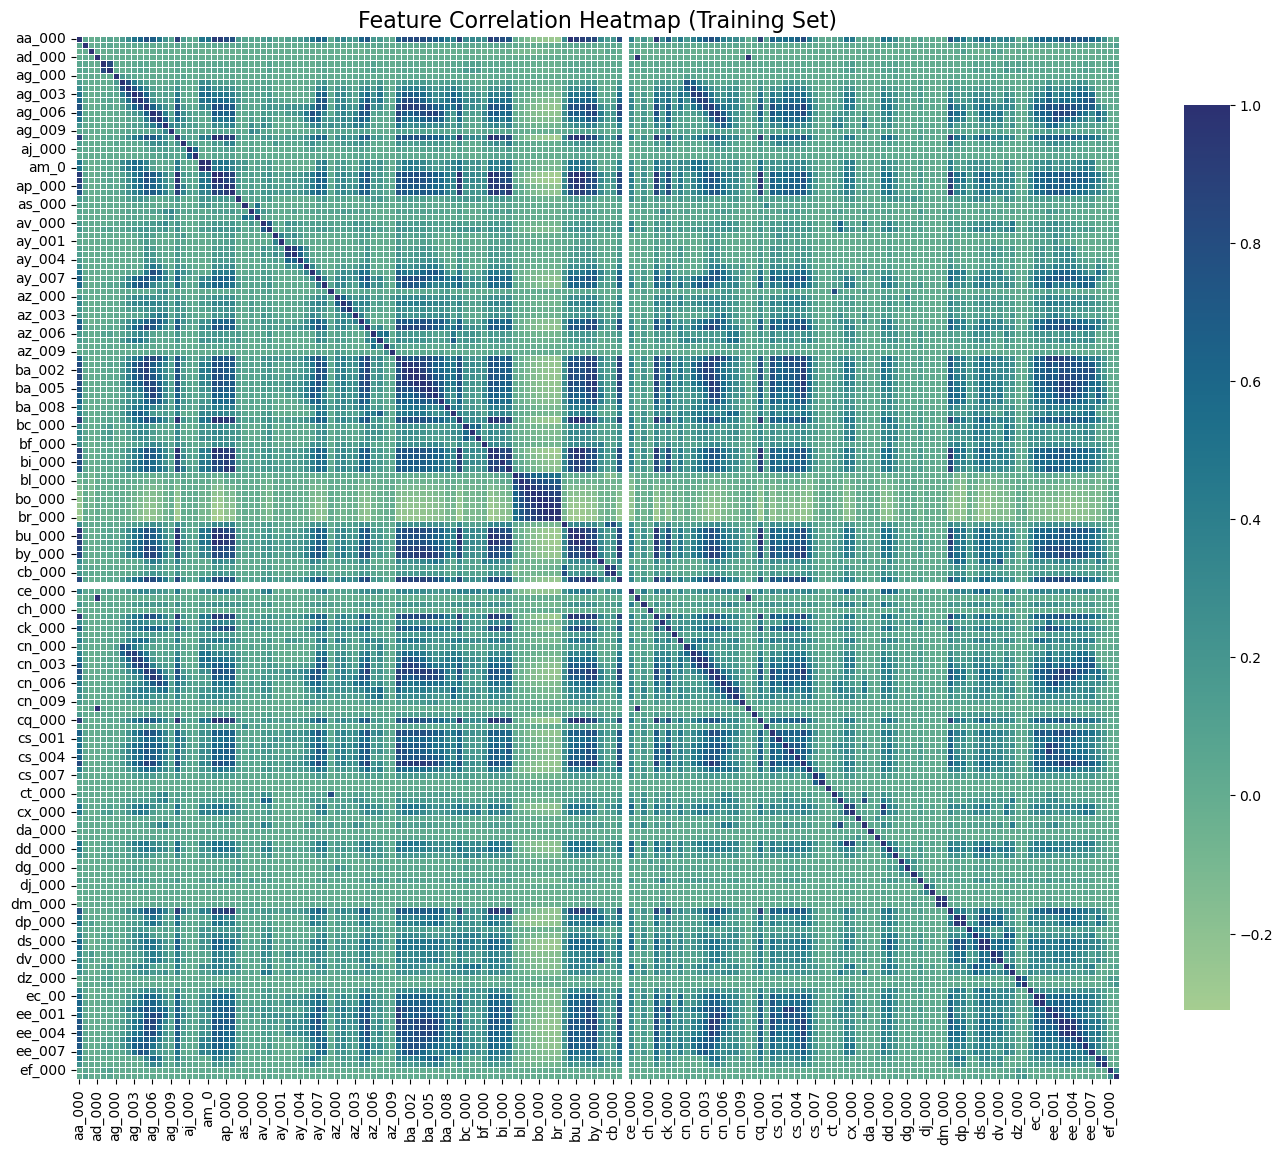

In [858]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_mat,
    cmap="crest",
    annot=False,        
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    square=True,
)
plt.title("Feature Correlation Heatmap (Training Set)", fontsize=16)
plt.tight_layout()
plt.show()

iv. Scatter plots and box plots

In [860]:
top_n = math.floor(math.sqrt(df_train_X_imputed.shape[1]))
top_features = coeff_of_var.loc['cv'].sort_values(ascending=False).head(top_n)

In [861]:
print("Features:")
top_features.to_frame(name='cv')

Features:


cv
cs_009  235.277605
cf_000  184.233092
co_000  183.949017
ad_000  183.847620
dh_000  114.984991
dj_000  109.647285
ag_000   91.878565
as_000   86.416904
ay_009   83.786063
az_009   76.967978
ak_000   74.526688
au_000   68.160554
ch_000   58.268229

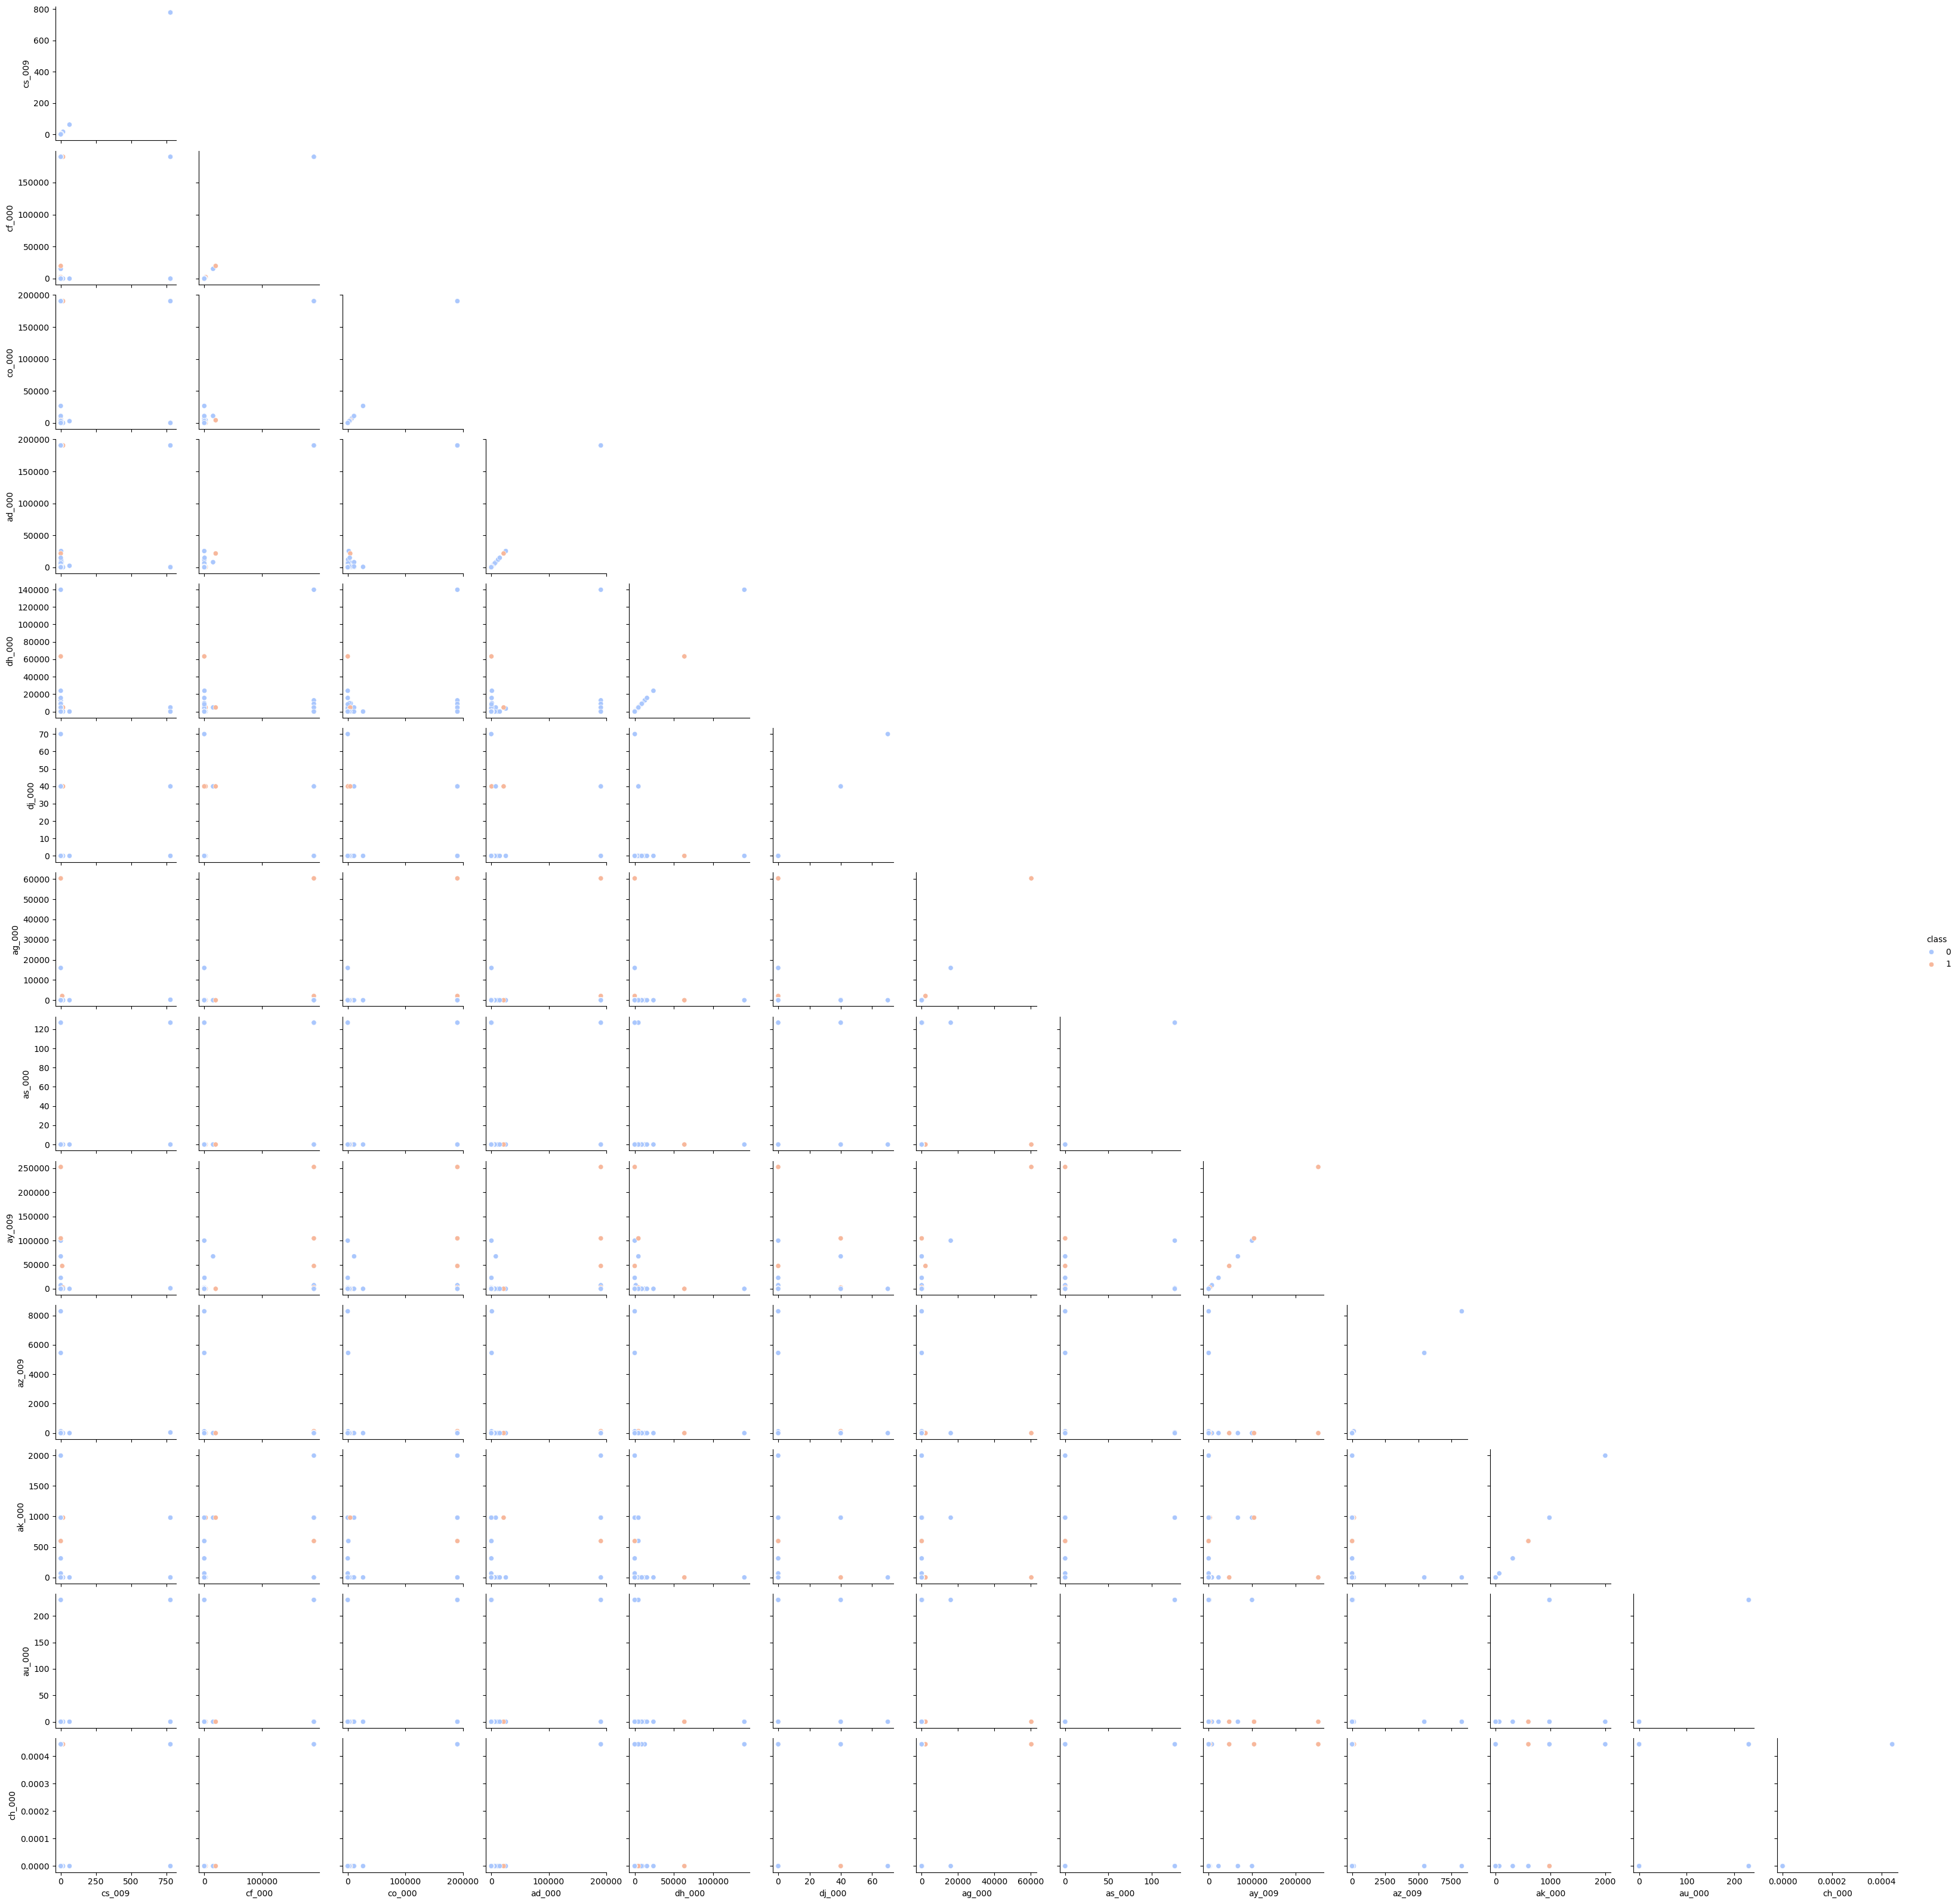

In [862]:
df_sample = df_train_X_imputed[top_features.index].sample(1000, random_state=42)
df_sample['class'] = df_train_Y.loc[df_sample.index].values  

sns.pairplot(data=df_sample, hue='class', palette='coolwarm', corner=True, diag_kind=None)


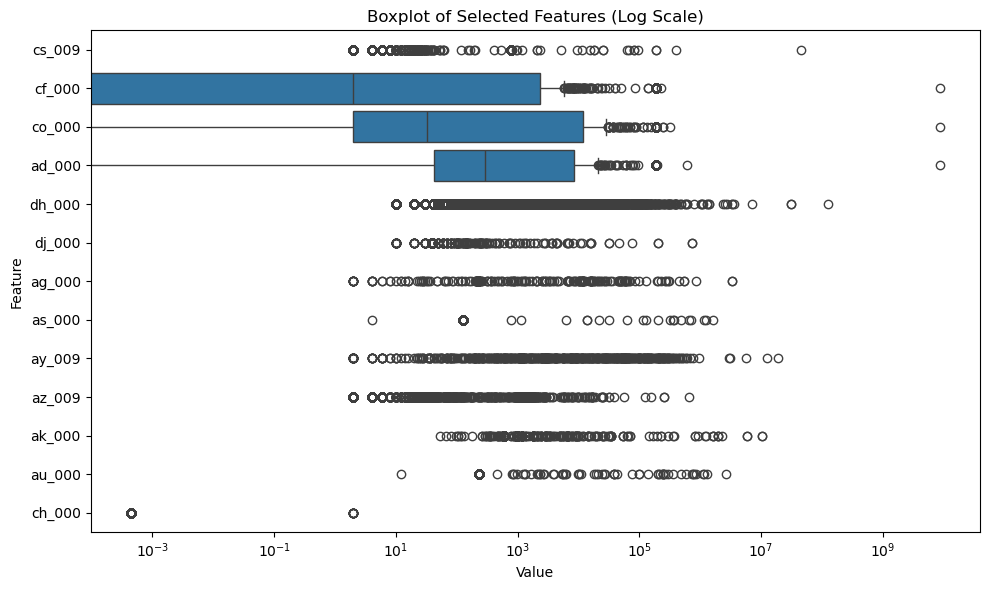

In [863]:
melted = df_train_X_imputed[top_features.index].melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x='Value', y='Feature')
plt.xscale('log')
plt.title("Boxplot of Selected Features (Log Scale)")
plt.tight_layout()
plt.show()

v. Determining the number of positive and negative data.

In [865]:
label_counts = df_train_Y.value_counts().to_dict()
print("Total positive values:", label_counts.get(1, 0))
print("Total negative values:", label_counts.get(0, 0))

Total positive values: 1000
Total negative values: 59000


*Yes, the dataset is clearly imbalanced. Out of the 60,000 training samples, 59,000 are labeled as negative and only 1,000 as positive. This means that the positive class makes up just about 1.67% of the data, while the negative class accounts for the remaining 98.33%.*

**(c) Training a random forest Model**

In [868]:
def evaluate_model(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    error = 1 - accuracy
    auc_score = roc_auc_score(y_true, y_prob[:, 1])
    
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {accuracy:.5f}")
    print(f"Error: {error:.5f}")
    print(f"AUC Score: {auc_score:.5f}")
    
    return cm, accuracy, error, auc_score

In [869]:
def plot_roc(y_true, y_prob, label="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

In [870]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    oob_score=True
)
rf.fit(df_train_X, df_train_Y)

RandomForestClassifier(oob_score=True, random_state=42)

In [871]:
train_preds = rf.predict(df_train_X)
train_probs = rf.predict_proba(df_train_X)

test_preds = rf.predict(df_test_X)
test_probs = rf.predict_proba(df_test_X)


In [872]:
print("Training Report:")
print(classification_report(df_train_Y, train_preds))

print("Testing Report:")
print(classification_report(df_test_Y, test_preds))


Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

Testing Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15625
           1       0.93      0.73      0.82       375

    accuracy                           0.99     16000
   macro avg       0.96      0.86      0.91     16000
weighted avg       0.99      0.99      0.99     16000



In [873]:
oob_error = 1 - rf.oob_score_
test_error = 1 - accuracy_score(df_test_Y, test_preds)
print(f"OOB Error: {oob_error:.5f}")
print(f"Test Error: {test_error:.5f}")

OOB Error: 0.00607
Test Error: 0.00756


Training Set Metrics
Confusion Matrix:
 [[59000     0]
 [    1   999]]
Accuracy: 0.99998
Error: 0.00002
AUC Score: 1.00000


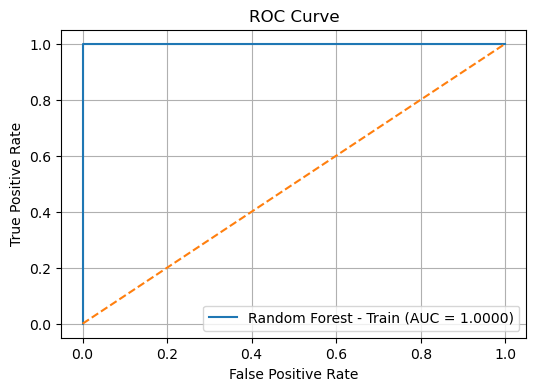

In [874]:
print("Training Set Metrics")
evaluate_model(df_train_Y, train_preds, train_probs)
plot_roc(df_train_Y, train_probs, label="Random Forest - Train")


Testing Set Metrics
Confusion Matrix:
 [[15605    20]
 [  101   274]]
Accuracy: 0.99244
Error: 0.00756
AUC Score: 0.99158


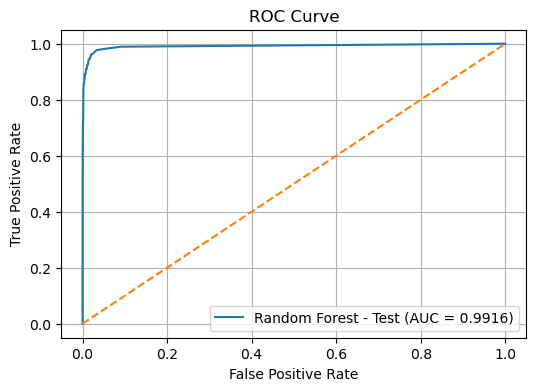

In [875]:
print("\nTesting Set Metrics")
evaluate_model(df_test_Y, test_preds, test_probs)
plot_roc(df_test_Y, test_probs, label="Random Forest - Test")


**(d) Researching class imbalance in random forest**

class_weight='balanced' in RandomForestClassifier</br>
Assigns weights to classes inversely proportional to their frequency. This makes the model pay more attention to the minority class without changing the dataset. Useful when imbalance is moderate.</br>
</br>
BalancedRandomForestClassifier from imblearn</br>
Builds each tree using a balanced bootstrap sample by randomly undersampling the majority class. This ensures equal class representation during training and works well for severe class imbalance.</br>

In [878]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    oob_score=True,
    class_weight='balanced',
    random_state=42
)
rf_balanced.fit(df_train_X_imputed, df_train_Y)

RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=42)

In [879]:
train_preds_bal = rf_balanced.predict(df_train_X_imputed)
train_probs_bal = rf_balanced.predict_proba(df_train_X_imputed)

test_preds_bal = rf_balanced.predict(df_test_X_imputed)
test_probs_bal = rf_balanced.predict_proba(df_test_X_imputed)

Training Set Metrics (Balanced Random Forest)
Confusion Matrix:
 [[59000     0]
 [    1   999]]
Accuracy: 0.99998
Error: 0.00002
AUC Score: 1.00000


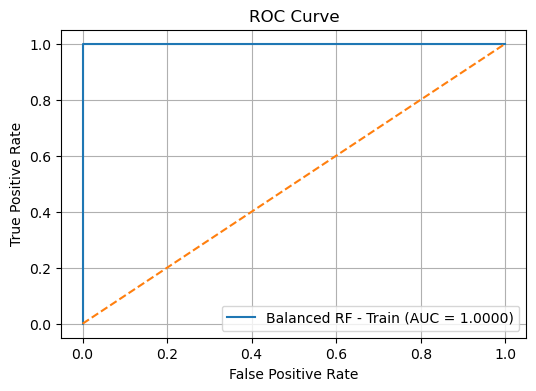

In [880]:
print("Training Set Metrics (Balanced Random Forest)")
evaluate_model(df_train_Y, train_preds_bal, train_probs_bal)
plot_roc(df_train_Y, train_probs_bal, label="Balanced RF - Train")


Testing Set Metrics (Balanced Random Forest)
Confusion Matrix:
 [[15613    12]
 [  166   209]]
Accuracy: 0.98887
Error: 0.01113
AUC Score: 0.98646


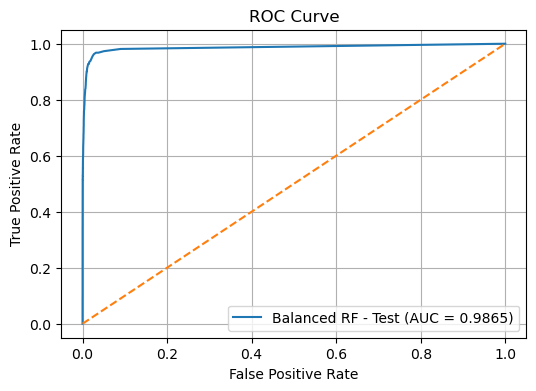

In [881]:
print("\nTesting Set Metrics (Balanced Random Forest)")
evaluate_model(df_test_Y, test_preds_bal, test_probs_bal)
plot_roc(df_test_Y, test_probs_bal, label="Balanced RF - Test")

In [882]:
oob_error_bal = 1 - rf_balanced.oob_score_
test_error_bal = 1 - accuracy_score(df_test_Y, test_preds_bal)
print(f"\nOOB Error (Balanced): {oob_error_bal:.5f}")
print(f"Test Error (Balanced): {test_error_bal:.5f}")


OOB Error (Balanced): 0.00768
Test Error (Balanced): 0.01113


In [883]:
print("\n Comparison ")
print(f"Unbalanced Test Error: {test_error:.5f}")
print(f"Balanced   Test Error: {test_error_bal:.5f}")
print(f"Unbalanced OOB Error : {oob_error:.5f}")
print(f"Balanced   OOB Error : {oob_error_bal:.5f}")


 Comparison 
Unbalanced Test Error: 0.00756
Balanced   Test Error: 0.01113
Unbalanced OOB Error : 0.00607
Balanced   OOB Error : 0.00768


**(e) XGBoost and Model Trees**

In [885]:
def evaluate_model(y_true, y_pred, y_prob, label="Model"):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    error = 1 - acc
    roc_auc = roc_auc_score(y_true, y_prob[:, 1])
    
    print(f"{label} Metrics:")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {acc:.5f}")
    print(f"Error: {error:.5f}")
    print(f"AUC: {roc_auc:.5f}")
    
    return {"confusion_matrix": cm, "accuracy": acc, "error": error, "auc": roc_auc}

In [886]:
def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [887]:
def tune_xgb_model(X, y, param_grid):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(objective='binary:logistic', colsample_bytree=0.3,
                              learning_rate=0.1, max_depth=5, 
                               eval_metric='logloss'))
    ])
    
    grid = GridSearchCV(pipe, 
                        param_grid={'xgb__reg_alpha': param_grid['reg_alpha']},
                        cv=KFold(n_splits=5, shuffle=True, random_state=69),
                        scoring='accuracy', 
                        n_jobs=-1)
    grid.fit(X, y)
    best_alpha = grid.best_params_['xgb__reg_alpha']
    return grid, best_alpha


In [888]:
def evaluate_xgb_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)
    
    y_test_pred = model.predict(X_test)
    y_test_prob = model.predict_proba(X_test)
    
    print("Training Evaluation")
    train_stats = evaluate_model(y_train, y_train_pred, y_train_prob, label="Train")
    plot_roc_curve(y_train, y_train_prob, title="ROC Curve - Train")
    
    print("\nTesting Evaluation")
    test_stats = evaluate_model(y_test, y_test_pred, y_test_prob, label="Test")
    plot_roc_curve(y_test, y_test_prob, title="ROC Curve - Test")
    
    return {"train": train_stats, "test": test_stats}


In [889]:
param_grid = {
    "reg_alpha": [0.01, 0.05, 0.07, 0.08, 0.1, 0.2]
}


In [890]:
grid_model, best_alpha = tune_xgb_model(df_train_X_imputed, df_train_Y, param_grid)
print("Best reg_alpha:", best_alpha)
print("Best CV Accuracy:", grid_model.best_score_)


Best reg_alpha: 0.08
Best CV Accuracy: 0.9939333333333333


Training Evaluation
Train Metrics:
Confusion Matrix:
[[58994     6]
 [   82   918]]
Accuracy: 0.99853
Error: 0.00147
AUC: 0.99930


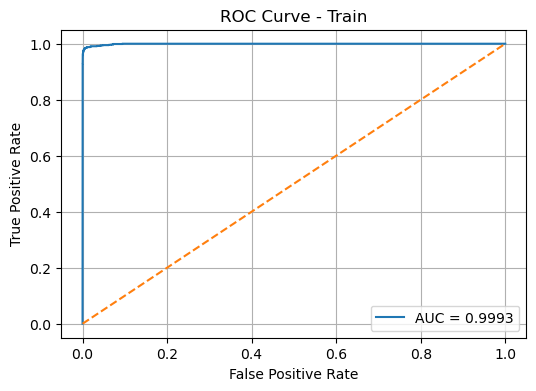


Testing Evaluation
Test Metrics:
Confusion Matrix:
[[15606    19]
 [   93   282]]
Accuracy: 0.99300
Error: 0.00700
AUC: 0.99588


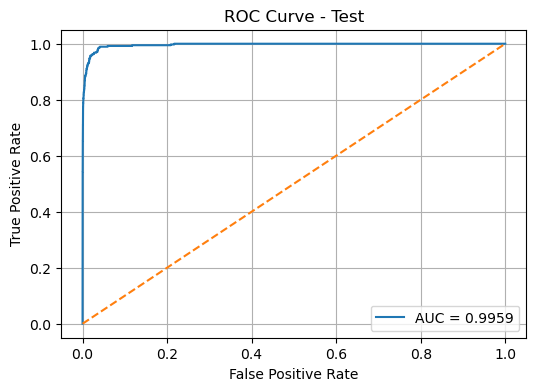

In [891]:
results = evaluate_xgb_model(grid_model.best_estimator_, df_train_X_imputed, df_train_Y, 
                             df_test_X_imputed, df_test_Y)
results['best_alpha'] = best_alpha

**SMOTE (Synthetic Minority Over-sampling Technique)**

In [893]:
def evaluate_performance(y_true, y_pred, y_prob, tag="Model"):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    error = 1 - accuracy
    roc_score = roc_auc_score(y_true, y_prob[:, 1])
    print(f"{tag} Performance:")
    print("Confusion Matrix:\n", cm)
    print(f"Accuracy: {accuracy:.5f}, Error: {error:.5f}, ROC AUC: {roc_score:.5f}\n")
    return {"confusion": cm, "accuracy": accuracy, "error": error, "auc": roc_score}


In [894]:
def plot_roc_curve_custom(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    roc_value = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_value:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [895]:
smote_pipeline = imbpipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(objective='binary:logistic', 
                          colsample_bytree=0.3,
                          learning_rate=0.1, 
                          max_depth=5,
                          eval_metric='logloss'))
])

In [896]:
param_grid_pipeline = {
    'xgb__reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.1, 0.2]
}

In [897]:
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(df_train_X_imputed), columns=df_train_X_imputed.columns)
x_test_scaled = pd.DataFrame(scaler.transform(df_test_X_imputed), columns=df_test_X_imputed.columns)

In [898]:
grid_search_smote = GridSearchCV(smote_pipeline, 
                                 param_grid_pipeline,
                                 cv=KFold(n_splits=5, shuffle=True, random_state=69),
                                 scoring='accuracy',
                                 n_jobs=-1)
grid_search_smote.fit(x_train_scaled, df_train_Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=69, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=0.3,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_...
                                                      learning_rate=0.1,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=5,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.1, 0.2]},
             scoring='accuracy')

In [899]:
best_alpha_smote = grid_search_smote.best_params_['xgb__reg_alpha']
print("Best reg_alpha (with SMOTE):", best_alpha_smote)
print("Best CV Accuracy (with SMOTE):", round(grid_search_smote.best_score_, 5))

Best reg_alpha (with SMOTE): 0.05
Best CV Accuracy (with SMOTE): 0.98907


Training Evaluation (with SMOTE)
Train with SMOTE Performance:
Confusion Matrix:
 [[58622   378]
 [   43   957]]
Accuracy: 0.99298, Error: 0.00702, ROC AUC: 0.99866



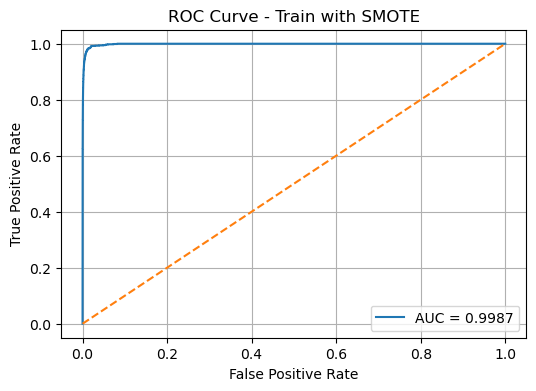

In [900]:
train_preds_smote = grid_search_smote.best_estimator_.predict(x_train_scaled)
train_probs_smote = grid_search_smote.best_estimator_.predict_proba(x_train_scaled)
print("Training Evaluation (with SMOTE)")
smote_train_stats = evaluate_performance(df_train_Y, train_preds_smote, train_probs_smote, tag="Train with SMOTE")
plot_roc_curve_custom(df_train_Y, train_probs_smote, title="ROC Curve - Train with SMOTE")

Testing Evaluation (with SMOTE)
Test with SMOTE Performance:
Confusion Matrix:
 [[15476   149]
 [   47   328]]
Accuracy: 0.98775, Error: 0.01225, ROC AUC: 0.99584



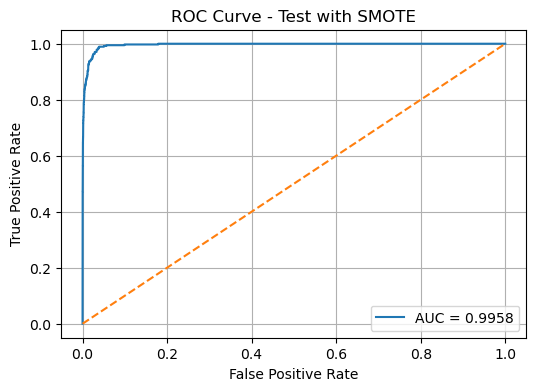

In [901]:
test_preds_smote = grid_search_smote.best_estimator_.predict(x_test_scaled)
test_probs_smote = grid_search_smote.best_estimator_.predict_proba(x_test_scaled)
print("Testing Evaluation (with SMOTE)")
smote_test_stats = evaluate_performance(df_test_Y, test_preds_smote, test_probs_smote, tag="Test with SMOTE")
plot_roc_curve_custom(df_test_Y, test_probs_smote, title="ROC Curve - Test with SMOTE")

In [902]:
comparison_df = pd.DataFrame({
    'Train Error': [results['train']['error'], smote_train_stats['error']],
    'Train Accuracy': [results['train']['accuracy'], smote_train_stats['accuracy']],
    'Train ROC': [results['train']['auc'], smote_train_stats['auc']],
    'Test Error': [results['test']['error'], smote_test_stats['error']],
    'Test Accuracy': [results['test']['accuracy'], smote_test_stats['accuracy']],
    'Test ROC': [results['test']['auc'], smote_test_stats['auc']]
}, index=['Without SMOTE', 'With SMOTE'])

In [903]:
print(comparison_df)

               Train Error  Train Accuracy  Train ROC  Test Error  \
Without SMOTE     0.001467        0.998533   0.999300     0.00700   
With SMOTE        0.007017        0.992983   0.998659     0.01225   

               Test Accuracy  Test ROC  
Without SMOTE        0.99300  0.995877  
With SMOTE           0.98775  0.995843  


 #### **References:** </br>
Scikit-learn documentation on imputation: https://scikit-learn.org/stable/modules/impute.html</br>
Towards Data Science article on missing data handling: https://towardsdatascience.com/handling-missing-data-in-machine-learning-using-python-b0a5e5ed70c6